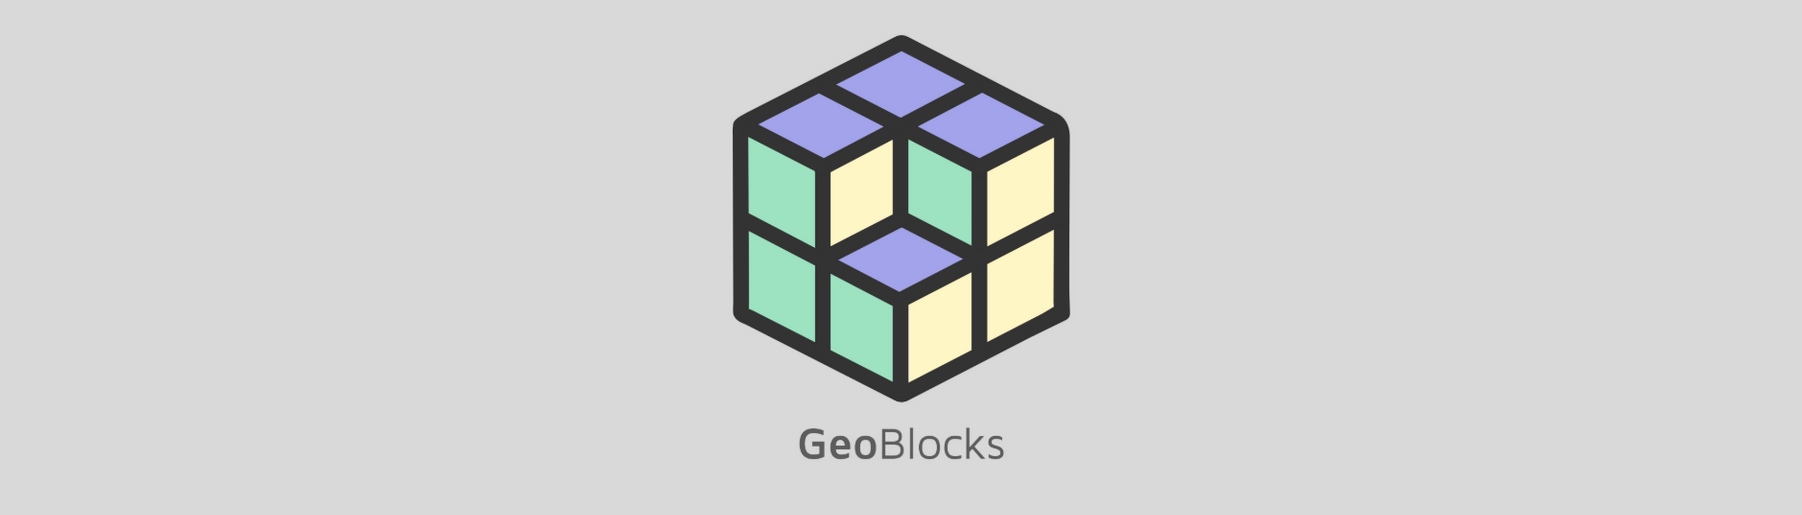

## GeoBlocks - your new friend for Big Data geo analysis

**GeoBlocks** was developed to make more efficient (real-time) GIS models using big geodata. GeoBlocks allows you to build on-the-fly GIS models directly on [**Lizard.**](http://lizard.net) using it's Raster Server & Vector Server.




**Open source**
-------------------------------------------------------------------------------------
GeoBlocks is published **open source** under the name *dask-geomodeling*. With dask geomodeling you can create on-the-fly GIS models on your local PC using python. The size of the models that you can make is then determined by your memory and processor and are therefore limited.
Do you want to use larger datasets in your model? You can do that by publishing your model to the GeoBlocks engine using the Lizard API. With the GeoBlocks engine you can scale up your models (in space and time). You can easily calculate with data sets of> 100GB and operationalize the models.


**Documentation**: 
- [**Lizard**](https://docs.lizard.net)
- [**GeoBlocks**](https://demo.lizard.net/doc/geoblocks.html#)
- [**dask-geomodeling**](https://dask-geomodeling.readthedocs.io/)


Would you like to contribute to the dask geomodeling project? Join the project on the [**github page!**](https://github.com/nens/dask-geomodeling/blob/master/docs/index.rst).   

 
 
**Let's get started**
------------------
This Notebook gives you a brief explanation of the basics of GeoBlocks. We will apply the tool in a tuturial about floods and the effect of floods.

Table of contents: 

- A short introduction in GeoBlocks. 
- Tutorial 1 - Floods & the effects of floods.







------------------------------------------------------------------------------------------------------------------------



# A short introduction into GeoBlocks (open source: dask-geomodeling)
GeoBlocks and dask geomodeling enable you to quickly derive data using GIS operations, rasters and vectors. The results of a GeoBlocks model are calculated on-the-fly, without the need of saving intermediate results. This makes GeoBlocks efficient in data storage. 

The operations available in the library are called `Blocks`. You will find all available `blocks` in the [**documentation**](https://demo.lizard.net/doc/geoblocks.html) The two basetype blocks are `RasterBlock()` and the `GeometryBlock()`.  

A collection of blocks is called a **graph** or **models** and describes the relationship between the data and the operations that you use to derive information.
The first example is defined below. 



## Step 1. Import modules

First we will import the required python modules.



In [2]:
import dask
from dask_geomodeling import raster 
from dask_geomodeling import geometry
from shapely.geometry import box

## Step 2. Define your first model.

- The first step is to define the input data. We do that with the block `raster.RasterFileSource`. In this case we define height and use the file * elevation.tif *
- We then define the operations that we want to apply to the input data. In this case we are going to raise the height map by 7 meters. For this we use the block `raster.elemwise.Add`.



In [3]:
elevation = raster.RasterFileSource("elevation.tif")
add = elevation + 7
add.serialize()


{'version': 2,
 'graph': {'RasterFileSource_1dacd0275a09047891a72cda87ca487f': ['dask_geomodeling.raster.sources.RasterFileSource',
   'file://C:\\Users\\joeri.verheijden\\Documents\\Lizard Workshop_EN\\Notebook-geoblocks\\GeoBlocks - dask-geomodeling\\elevation.tif',
   0,
   300000],
  'Add_b2314460c6d155f3d2b4991c7d699dc3': ['dask_geomodeling.raster.elemwise.Add',
   'RasterFileSource_1dacd0275a09047891a72cda87ca487f',
   7]},
 'name': 'Add_b2314460c6d155f3d2b4991c7d699dc3'}

## Step 3. Derive results
The **model** is now defined and you can now derive results from the file *hoogte.tif*.

The **derivation** of the **results** takes place within a **bounding box** and in a certain **resolution**.
The bounding box can be smaller than the extent of the input data set.

**Example**:
A grid is 24x24 meters (black), but we derive the results for an area of 9x9 meters (bounding box in orange). We choose a resolution of 3x3 pixels in which we derive the result (blue).

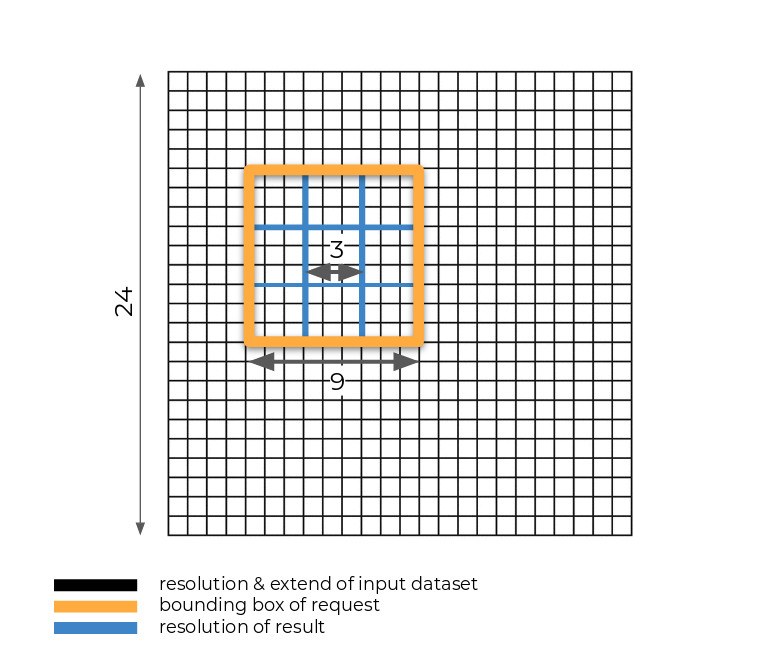

Below is the *request* and we get the results back in an *array*.


In [4]:
request = dict(
    mode="vals",
    bbox=[574803, 6840620, 575803, 6841620],
    projection="epsg:3857",
    height=100,
    width=100,
)
add.get_data(**request)

{'no_data_value': 3.4028234663852886e+38,
 'values': array([[[26.847   , 26.818388, 26.923334, ..., 16.573105, 15.99516 ,
           7.      ],
         [26.988455, 26.887304, 27.089052, ..., 16.364853, 15.921029,
           7.      ],
         [27.058481, 27.046354, 27.170923, ..., 16.26935 , 15.824568,
           7.      ],
         ...,
         [25.483044, 25.802462, 25.837687, ..., 15.008397, 15.009012,
           7.      ],
         [25.387661, 25.807863, 25.869507, ..., 14.979658, 14.981491,
           7.      ],
         [ 7.      ,  7.      ,  7.      , ...,  7.      ,  7.      ,
           7.      ]]], dtype=float32)}

## Step 4. Results on the map

An *array* can be useful, but it's nice to see geo information on the map. We use a map plugin for this called *ipyleaflet*.

In the previous step you saw that the results of a *model* are always derived within a bounding box. We can link that bounding box to the card plugin. The information is then calculated for the area that you have in the map plugin. As soon as you go to another area on the map, the information for this new area is derived (if that area falls within the extend of the input grid).



In [5]:
from dask_geomodeling.ipyleaflet_plugin import GeomodelingLayer
from ipyleaflet import Map, basemaps, basemap_to_tiles

def make_map(view, style="viridis", vmin=0, vmax=10, opacity=0.5, zoom=15):
    geoomdeling_layer = GeomodelingLayer(view, styles=style, vmin=vmin, vmax=vmax, opacity=opacity)
    osm_layer = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)

    extent = view.extent
    if extent is None:
        center = 52.226649, 5.120766
    else:
        center = ((extent[1] + extent[3]) / 2, (extent[0] + extent[2]) / 2)
    m = Map(
        center=center,
        zoom=zoom,
        layers=[osm_layer, geoomdeling_layer]
    )
    return m




First we plot the original data of *hoogte.tif* on the map


In [7]:
make_map(elevation, vmin=0, vmax=20, opacity=0.9)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Then we plot the result of the `Add` model (height + 7) on the map. Note that the result is calculated within the bounding box of the ticket. As soon as you navigate to another area, the model `Add` derives the information for that new area and you see the resuts appear on the map.

When you adjust the model `Add` to 'Add + 3' you can see the result directly on the map below.

In [8]:
make_map(add + 3, vmin=0, vmax=20, opacity=0.9)
#make_map(add + 3, vmin=0, vmax=20, opacity=0.9)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

------------------------------------------------------------------------------------------------------------------------

# Tutorial 1. Floods and the effects of a flood

In this tutorial we will investigate a flood near Hilversum. Step by step  we will map the effects of a flood:

- Where and how deep does the water reach when the water level rises to 2mNAP?

- Which buildings flood during such a flood?

- Which roads are still passable during such a flood?


We use a number of open data sets
- A piece of AHN2 near Hilversum (GeoTIFF of 142 MB)
- Piece of the National Road Database (Shapfile of 3 MB)
- A combined land use card (composed of the bag, bgt, nwb, top10 and a number of other sources). (3 MB GeoTIFF)

## Step 1. A water level  of 2mMSL?! Which areas will be flooded? 

The area of Hilversum has a lot of height difference. The Loosdrecht lakes are, for example, below NAP and Hilversum itself far above NAP. We will investigate how far the water reaches when the river dike of the Vecht breaks through near Loenen aan de Vecht. We will calculate the water depth and assume that the water level rises to 2 mNAP.

- we first define the water depth. We do this by subtracting the *hoogte* from 2mNAP. We use block `raster.Subtract` for this
- naturally we create negative values. Of course there is no negative water depth, so we mask all values below 0. We do that with block `raster.MaskBelow`




In [9]:
waterdepth = raster.MaskBelow(raster.Subtract(2, elevation), 0) 
make_map(waterdepth, style="Blues", vmin=0, vmax=2, opacity=0.9)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## Step 2. Creating a floor level
We use a combined land use raster to investigate which buildings are flooded. Buildings in the classified land use map have class value 2 (buildings come from the Dutch Base Registration for Buidlings (BAG)).

Buildings have a floor level. So in order to make a more accurate analysis, we first elevate the height map on the spots where buildings occur to create a flood level. 
For the sake of convenience we assume that every building in the area has a floor level of 0.3 m

We do this by following this step-by-step plan:
- we first define the location of the grid with `raster.RasterFileSource`

In [10]:
landuse = raster.RasterFileSource("landuse.tif")
make_map(landuse, style='jet', opacity=0.9)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

- the buildings have class 2 in the land use grid.
- We "clip" the elevation map where the land use map has a value of "2". That way we know what the ground level is at the locations of the buildings. For this we use `raster.Clip`


In [11]:
buildings = landuse==2
buildings_terrain = raster.Clip(elevation, buildings)
make_map(buildings_terrain, style='viridis', opacity=0.9)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

- We then raise the ground level by 0.3 m to create a floor level.
- Then we combine the height map and the floor levels and we plot the map. For this we use `raster.Group`
- The difference of 0.3 m is almost invisible due to the styling. When you make the floor level just 200m you will see the result clearly on the map.
- Then change the floor level to 0.3 m again

In [12]:
floorlevel = buildings_terrain + 0.3
combine_elevation_floorlevel = raster.Group(elevation, floorlevel)
make_map(combine_elevation_floorlevel, opacity=0.9)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## Step 3. Which buildings are flooded?
We will then combine the previously defined water depth *graph* with the floor level to analyze which buildings are flooded and how high the water is in the building.

- we create the *graph* water depth_ properties in which the floor level is subtracted from the water depth. For that we use block `raster.Subtract`
- then we again mask all values below 0 with `raster.Maskbelow`
- then we plot the results on the map with `make_map '
- you see red buildings appearing around the Beresteinseweg

In [14]:
waterdepth_buildings = raster.MaskBelow(raster.Subtract(waterdepth, floorlevel), 0)
make_map(waterdepth_buildings, style="Reds", vmin=0, vmax=0.1, opacity=0.9)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## Step 4. Which roads are still passable? A different approach with Geometries.
During a flood it is important to know whether roads are still passable so that they can be used for evacuation.

We will use the same water depth *graph* for this. We use line geometries from the National Road Database for the roads.

- first we define the location of the geometry with the block `GeometryFileSource`
- we also give that geometry a 5 meter buffer with the block `geometry.Buffer`. This is how we create a road section
- we then combine those geometries with the water depth *graph* in a *graph* and look for the maximum water depth value within the road sections. We do this with the block `geometry.AggregateRaster`
- We then request the result again in a bounding box with `get_data '
- The result is now a table with the road sections and the maximum water depth per road section.

In [19]:
roads = geometry.GeometryFileSource("roads/Target.shp", id_field="WVK_ID")

road_sections = geometry.Buffer(roads, 10, projection="EPSG:3857")

waterdepth_on_road_sections = geometry.AggregateRaster(
    road_sections, waterdepth, statistic="min", projection="EPSG:3857", pixel_size=1, column_name="waterdepth_on_road_sections"
)

waterdepth_on_road_sections.get_data(
    mode="intersects",
    geometry=box(569742.4996,6841067.4527,571256.9082,6842110.1015),
    projection="epsg:3857",
)["features"]["waterdepth_on_road_sections"]

WVK_ID
600203535    1.007
600203534    0.198
600203537    0.995
273343014    1.243
273342002    0.407
600203536    1.335
Name: waterdepth_on_road_sections, dtype: float32

## Step 5. Results on the map
Within dask-geomodeling there is not yet a block to plot geometries on the map. To plot the accessibility of roads on the map, we will therefore first rasterize the geometries.

- We use the `Rasterize` block for this
- then we plot the grid on the map

In [20]:
rasterize_waterdepth_on_road_section = raster.Rasterize(waterdepth_on_road_sections, "waterdepth_on_road_sections", dtype="float64", limit=20)
make_map(rasterize_waterdepth_on_road_section, style="Reds", vmin=0.3, vmax=2, opacity=0.8, zoom=22)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

------------------------------------------------------------------------------------------------------------------------

## Thanks!
Thank you for going through this Notebook. We hope that you have learned a lot about the operation of GeoBlocks and dask geomodeling. Do you want more information about the possibilities of using GeoBlocks and dask geomodeling within your organization? Then contact us via info@lizard.net. We are happy to help you further!

## We’d love to hear your feedback on this Notebook. 
We'd love to hear your feedback on this Notebook. Were things unclear? Do you want to give us a thumbs up? Or would you like us to create another Notebook covering other aspects of GeoBlocks? Let us know via info@lizard.net 